Here we use fluorescent intensity data to estimate a thinning rate for an ode model to predict tear film thinning. 
The model comes from:  
Braun, Richard J., et al. "A model for tear film thinning with osmolarity and fluorescein." Investigative ophthalmology & visual science 55.2 (2014): 1133-1142.
https://iovs.arvojournals.org/article.aspx?articleid=2189506 

Scalings come from:  
Luke, Rayanne A., et al. "Parameter estimation for mixed-mechanism tear film thinning." Bulletin of Mathematical Biology 83.5 (2021): 1-39.  
This paper also describes conversion of fcr (critical fluorescein concentration) from percent to Molarity.
https://arxiv.org/pdf/2010.03670.pdf 

Data comes from (figure 3):  
Driscoll, Tobin A., et al. "Fitting ODE models of tear film breakup." arXiv preprint arXiv:2210.03593 (2022). 
https://arxiv.org/pdf/2210.03593.pdf  

Originial Julia code from Toby Driscoll is found here:  
https://github.com/tobydriscoll/TBUFitting.jl   
I checked my unit conversion with this code; especially conversion of fcr from percent to mol fraction. 

See also:  
Luke, Rayanne A., et al. "Parameter estimation for evaporation-driven tear film thinning." Bulletin of Mathematical Biology 82.6 (2020): 1-41.
https://link.springer.com/content/pdf/10.1007/s11538-020-00745-8.pdf 

In [72]:
#@title
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.integrate import solve_ivp
from scipy.optimize import minimize


In [73]:
#url = 'https://raw.githubusercontent.com/mjgocken/DRP_project/main/01_01_01_0.csv'
#url = 'https://raw.githubusercontent.com/mjgocken/DRP_project/main/01_01_06_0.csv'
#url = 'https://raw.githubusercontent.com/mjgocken/DRP_project/main/d4_v20_ts7.csv'
url = 'https://raw.githubusercontent.com/mjgocken/DRP_project/main/d2_v4_5_ts9.csv'
df = pd.read_csv(url,header=None)

In [74]:
#@title
I_data = df.T.to_numpy()
t0 = I_data[0,0] # start time
ts = I_data[-1,0] - I_data[0,0] # trial length
initial_I = I_data[0,1] # initial intensity
print('The trial length is',ts,'seconds')
print('The initial time is',t0)
print('The initial intensity is',initial_I)

The trial length is 9.0 seconds
The initial time is 0.0
The initial intensity is 1.023386293941676


In [75]:
#@title
#normalize time
t_norm=[(I_data[:,0]-I_data[0,0])/ts]
I_norm = [I_data[:,1]/I_data[0,1]]
test = np.vstack((t_norm,I_norm))
#print(test.shape)
#print(test)

In [76]:
#@title
# Functions needed 
'''
def intensity(thickness, phi, f0, I_0):
  I = np.zeros(len(thickness))
  for i in range(len(thickness)):
    I = I_0*(1-np.exp(- phi*f0))/(1+np.square(np.divide(f0,thickness)))
  return I;
'''
def intensity(thickness, phi, f, I_0):
  I = I_0*(1-np.exp(- phi*f0))/(1+np.square(np.divide(f0,thickness)))
  return I;

def solveTF(t_begin, t_end, t_nsamples, t_space, h_init, Pc, f0, I_0, v): 
  thickness = np.zeros(t_nsamples)
  method = 'RK45' #available methods: 'RK45', 'RK23', 'DOP853', 'Radau', 'BDF', 'LSODA'
  num_sol = solve_ivp(ode_fn(v,Pc), [t_begin, t_end], [h_init], method=method, dense_output=True)
  thickness = num_sol.sol(t_space)

  #return thickness, 1/thickness, f0/thickness, intensity(thickness, phi, f0, I_0);
  return thickness, 1/thickness, f0/thickness, intensity(thickness, phi, f0/thickness, I_0);

# Calulates the RHS of the ode - depends on value of v and Pc
def ode_fn(v,Pc):
  return lambda t, h : - v + Pc*(1/h - 1);

def objective(v, t_begin, t_end, t_nsamples, t_space, h_init, Pc, f0, I_0):
  #(v)
  thickness, c, f, I = solveTF(t_begin, t_end, t_nsamples, t_space, h_init, Pc, f0, I_0, v)
 # print(I)
  SS = np.linalg.norm(I - test[1,:])**2/t_nsamples
  #print(SS)
  return SS

def thickness_plot(t_space, thickness, d, ax): 
  ax.plot(t_space, thickness.T, '-', linewidth=2,label='predicted')
  ax.set_title('thickness')
  ax.tick_params(bottom=True, top=False, left=True, right=True)
  ax.set_xlabel('$t$')
  ax.set_ylabel('$h$')
  #ax.set_xlim([0, 3])
  #ax.set_ylim([0, 1])
  ax.legend()
  return;

def intensity_plot(t_space, I, test, ax):
  ax.plot(t_space, I.T, '-', linewidth=2,label='predicted')
  ax.scatter(test[0,:],test[1,:],label='actual')
  ax.set_title('fluorescent intensity')
  ax.tick_params(bottom=True, top=False, left=True, right=True)
  ax.set_xlabel('$t$')
  ax.set_ylabel('$I$')
  #ax.set_xlim([0, 3])
 # ax.set_ylim([0, 200])
  ax.legend()

def osmolarity_plot(t_mat, c, d, ax):
  ax.plot(t_mat, c.T, '-', linewidth=2,label='predicted')
  ax.set_title('osmolarity')
  ax.tick_params(bottom=True, top=False, left=True, right=True)
  ax.set_xlabel('$t$')
  ax.set_ylabel('$c$')
  #ax.set_xlim([0, 3])
  #ax.set_ylim([0, 8])
  ax.legend()

def fluorescein_plot(t_mat, f, ax):
  ax.plot(t_mat, f.T, '-', linewidth=2,label='predicted')
  ax.set_title('fluorescein')
  ax.tick_params(bottom=True, top=False, left=True, right=True)
  ax.set_xlabel('$t$')
  ax.set_ylabel('$f$')
  #ax.set_xlim([0, 3])
  #ax.set_ylim([0, 8])
  ax.legend()

def thickness_plot_dim(t_dim, thickness, d, ax): 
  thickness_dim = thickness * d
  ax.plot(t_dim, thickness_dim.T, '-', linewidth=2,label='predicted')
  ax.set_title('thickness')
  ax.tick_params(bottom=True, top=False, left=True, right=True)
  ax.set_xlabel('$t\; (s)$')
  ax.set_ylabel('$h\; (\mu m)$')
  #ax.set_xlim([0, 3])
  #ax.set_ylim([0, 1])
  ax.legend()
  return;

def intensity_plot_dim(t_dim, I, test, initial_I, ax):
  I_dim = initial_I*I
  ax.plot(t_dim, I_dim.T, '-', linewidth=2,label='predicted')
  ax.scatter(test[0,:],test[1,:],label='actual')
  ax.set_title('fluorescent intensity')
  ax.tick_params(bottom=True, top=False, left=True, right=True)
  ax.set_xlabel('$t\; (s)$')
  ax.set_ylabel('$intensity$')
  #ax.set_xlim([0, 3])
 # ax.set_ylim([0, 200])
  ax.legend()

def osmolarity_plot_dim(t_dim, c, c0, d, ax):
  c_dim = c * c0 * 1e18 # convert to mol/m^3
  ax.plot(t_dim, c_dim.T, '-', linewidth=2,label='predicted')
  ax.set_title('osmolarity')
  ax.tick_params(bottom=True, top=False, left=True, right=True)
  ax.set_xlabel('$t\; (s)$')
  ax.set_ylabel('$c \;(mol/m^3)$')
  #ax.set_xlim([0, 3])
  #ax.set_ylim([0, 8])
  ax.legend()

def fluorescein_plot_dim(t_dim, f, fcr, d, ax):
  f_dim =  fcr * f * 100 # fl concentation in percent
  ax.plot(t_dim, f_dim.T, '-', linewidth=2,label='predicted')
  ax.set_title('fluorescein')
  ax.tick_params(bottom=True, top=False, left=True, right=True)
  ax.set_xlabel('$t\; (s)$')
  ax.set_ylabel('$f\; (\%)$')
  #ax.set_xlim([0, 3])
  #ax.set_ylim([0, 8])
  ax.legend()

In [77]:
# Define the problem
t_begin=0.
t_end=1.
t_nsamples=len(I_data)
t_space = np.linspace(t_begin, t_end, t_nsamples)
h_init = 1 

fcrM = .0053 # critical fl concentration in Molar which is .2 percent
fcr = .002 # critical fl concentration in mol fraction
e_f = 17.5 # extinction coeff in micrometers^-1 M^-1 (1.75e7 m^-1 M^-1)
Ptiss = 12 # corneal permeability in micrometers/s
Vw = 18e12 # molar volume of water in micrometers^3/mol (18 cm^3/mol)
c0 = 300e-18 # isosmolar concentration in mol/micrometer^3 (300 mol/m^3)
f0 = 0.001737140/fcr # critical fl concentration nondimensionalized
#d = 2.49681 # initial height in micrometers
d = 2

phi = e_f*fcrM*d
Pc = (Ptiss*Vw*c0*ts)/d

I_0 = (1+(f0)**2)/(1-np.exp(-phi*f0*h_init)) # solve for I_0
v = 7.72*ts/(60*d) #initial guess for thinning rate (8 micrometer/min) scale by ts/(60d)
#v=.86
vmin, vmax = 0, 40*ts/(60*d)
bounds = [(vmin,vmax)]
print('I_0 =',I_0)
print('phi =',phi)
print('Pc =',Pc)
print('v =',v)
print('f0 = ',f0)
print('bounds = ',bounds)

I_0 = 11.789635016829235
phi = 0.1855
Pc = 0.29159999999999997
v = 0.5790000000000001
f0 =  0.8685700000000001
bounds =  [(0, 3.0)]


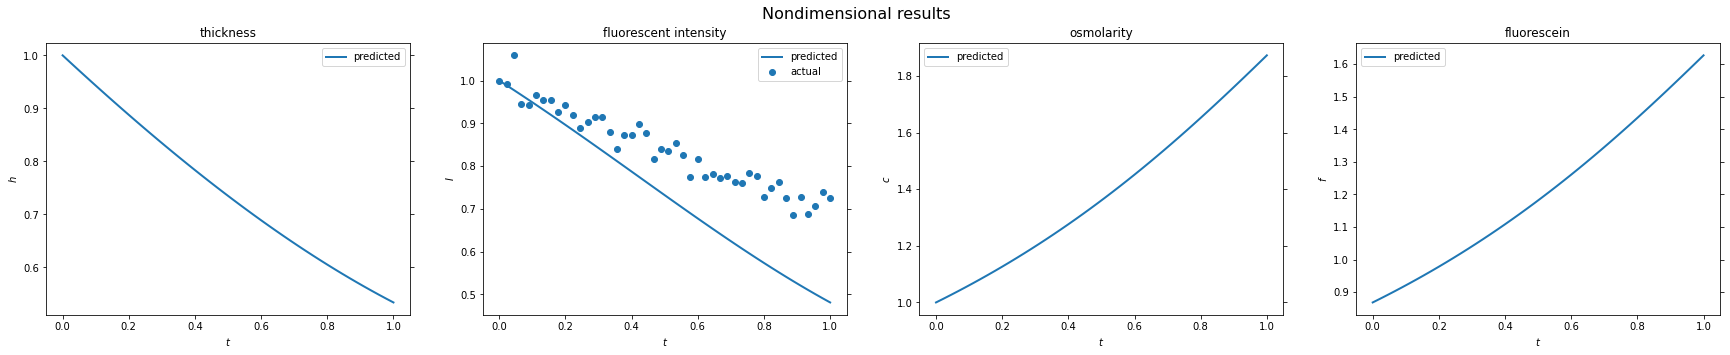

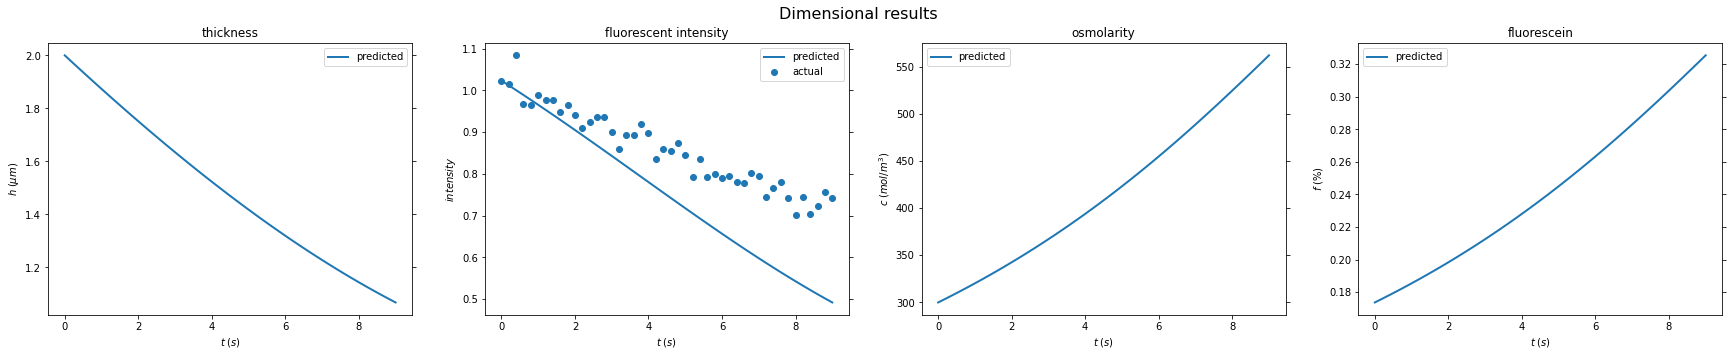

In [78]:
thickness, c, f, I = solveTF(t_begin, t_end, t_nsamples, t_space, h_init, Pc, f0, I_0, v)
thickness_dim = thickness*d
t_dim = ts*t_space + t0

fig, ax = plt.subplots (1,4,figsize=(30,5))
thickness_plot(t_space, thickness, d, ax[0])
intensity_plot(t_space, I, test, ax[1])
osmolarity_plot(t_space, c, d, ax[2])
fluorescein_plot(t_space, f, ax[3])
fig.suptitle('Nondimensional results',fontsize=16)
plt.show()

fig, ax = plt.subplots (1,4,figsize=(30,5))
thickness_plot_dim(t_dim, thickness, d, ax[0])
intensity_plot_dim(t_dim, I, I_data.T, initial_I, ax[1])
osmolarity_plot_dim(t_dim, c, c0, d, ax[2])
fluorescein_plot_dim(t_dim, f, fcr, d, ax[3])
fig.suptitle('Dimensional results',fontsize=16)
plt.show()

In [79]:
result = minimize(objective, .1, (t_begin, t_end, t_nsamples, t_space, h_init, Pc, f0, I_0), bounds = bounds, method='nelder-mead',tol=1e-6)

In [80]:
# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
solution = result['x']
evaluation = objective(solution,t_begin, t_end, t_nsamples, t_space, h_init, Pc, f0, I_0)
print('Value of the objective function is %.5f' % (evaluation))
#result

Status : Optimization terminated successfully.
Total Evaluations: 46
Value of the objective function is 0.00056


Estimated thinning rate is v = 4.82 micrometers/sec


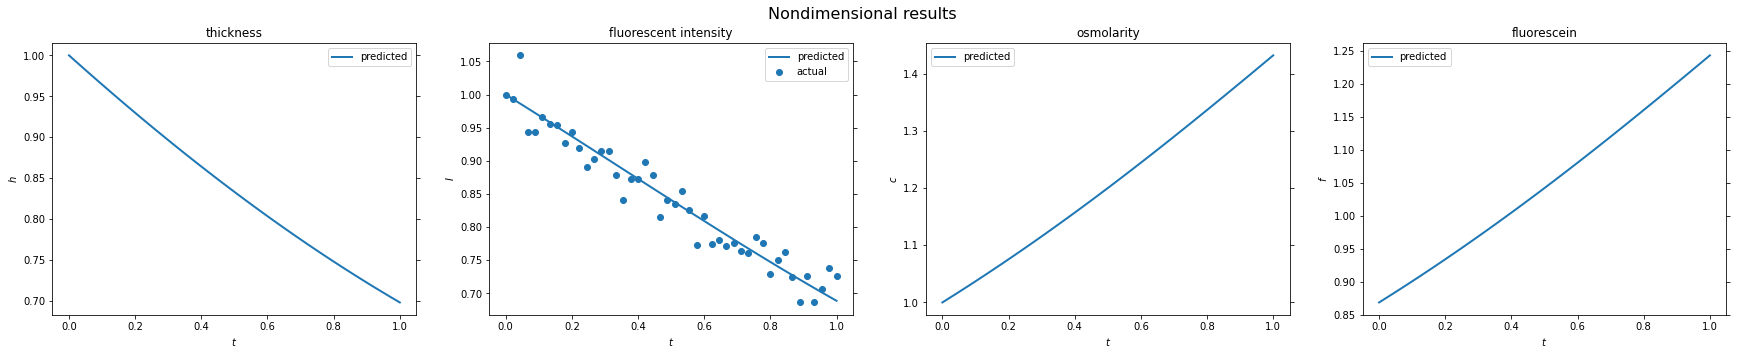

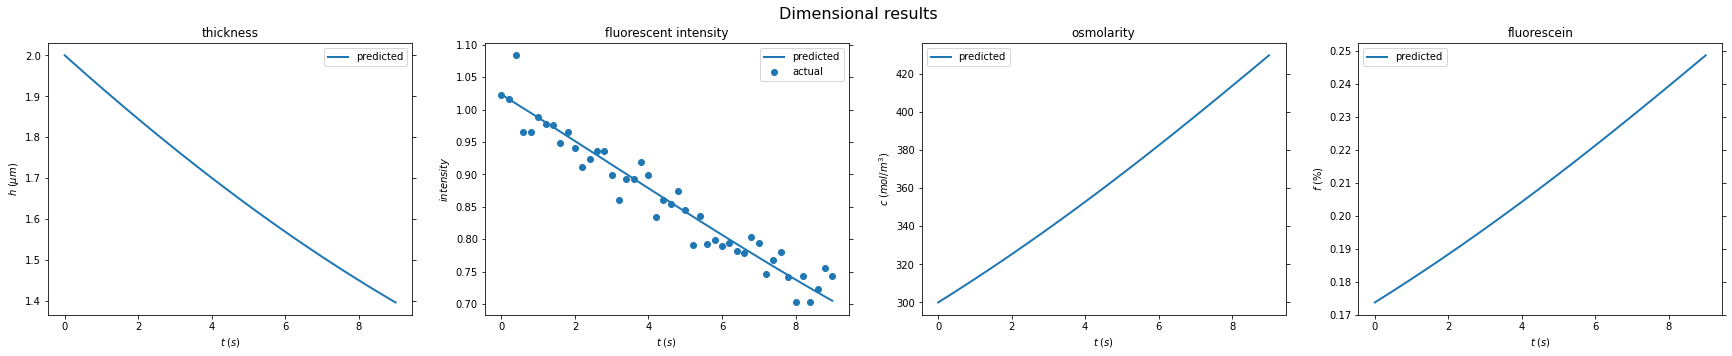

In [81]:
thickness, c, f, I = solveTF(t_begin, t_end, t_nsamples, t_space, h_init, Pc, f0, I_0, result.x[0])
t_dim = ts*t_space + t0

print('Estimated thinning rate is v = {:.2f} micrometers/sec'.format(result.x[0]*(60*d)/ts))

fig, ax = plt.subplots (1,4,figsize=(30,5))
thickness_plot(t_space, thickness, d, ax[0])
intensity_plot(t_space, I, test, ax[1])
osmolarity_plot(t_space, c, d, ax[2])
fluorescein_plot(t_space, f, ax[3])
fig.suptitle('Nondimensional results',fontsize=16)
plt.show()

fig, ax = plt.subplots (1,4,figsize=(30,5))
thickness_plot_dim(t_dim, thickness, d, ax[0])
intensity_plot_dim(t_dim, I, I_data.T, initial_I, ax[1])
osmolarity_plot_dim(t_dim, c, c0, d, ax[2])
fluorescein_plot_dim(t_dim, f, fcr, d, ax[3])
fig.suptitle('Dimensional results',fontsize=16)
plt.show()